In [29]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm
from quantimpy import morphology as mp
from quantimpy import minkowski as mk

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [30]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [31]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID = 'DiscreteSBM_SigmaVPSDE_I_BPROJ_N_4000_bottleneck_32_firstc_10_phi'

In [33]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


## Summary statistics

### Power Spectrum

In [34]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##

max_num_samples = 128

## Get results from the sample_dir corresponding to the diffuser
samples = torch.from_numpy(get_samples(diffuser))
if len(samples.shape) == 3:
    samples = samples.unsqueeze(1).to(device)

#samples = diffuser.diffmodel.generate_image(64, verbose = False)
label_samp = diffuser.config["model_id"]
try:
    label_dataset = diffuser.config["dataloaders"]["dataset"]["name"]
except:
    label_dataset = "Dataset"
## Get elements of the dataset
dataset = diffuser.train_dataloader.dataset
shape = dataset[0].shape
if len(shape) == 3:
    datapoints = torch.cat([dataset[i].reshape(1,-1,shape[1], shape[2]) for i in range(min(len(dataset), max_num_samples))]).to(device)
elif len(shape) == 2:
    datapoints = torch.cat([dataset[i].reshape(1,1,shape[0], shape[1]) for i in range(min(len(dataset), max_num_samples))]).to(device)
else:
    datapoints = torch.cat([dataset[i] for i in range(min(len(dataset), max_num_samples))]).to(device)

## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
for data in [samples, datapoints]:
    mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True)
    mean_list.append(mean_)
    std_list.append(std_)

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [35]:
ps_bins = bins_centers.cpu()
ps_orig = mean_list[1][:-1]
ps_orig_std = std_list[1][:-1]
ps_samples = mean_list[0][:-1]
ps_samples_std = std_list[0][:-1]

### Minkowski functionnals

In [36]:
samples = basics.get_samples(diffuser)
l_samples = np.split(samples, len(samples), axis=0)
l_samples = [l_samples[i][0][0] for i in range(len(l_samples))]

dataset = diffuser.train_dataloader.dataset

num_dataset_samples = 128

l_dataset = [dataset[i].numpy().copy(order = 'C') for i in range(num_dataset_samples)]

range_min = -3

range_max = 6

gs_vals = np.linspace(range_min, range_max, 200)

sampwise_minkmean  = []
sampwise_minkstd = []
for samp in [l_dataset,l_samples]:
    samp_minks = []
    for isa in range(len(samp)):#each image
        image = samp[isa]
        gs_masks = [image>=gs_vals[ig] for ig in range(len(gs_vals))]
        minkowski = []
        for i in range(len(gs_masks)):
            minkowski.append(mk.functionals(gs_masks[i], norm=True))
        minkowski = np.vstack(minkowski) #N_alphax3
        samp_minks.append(minkowski)
    samp_minks = np.stack(samp_minks) #NsampxN_alphax3
    sampwise_minkmean.append(samp_minks.mean(0))
    sampwise_minkstd.append(np.std(samp_minks, axis=0, ddof=1))

In [37]:
mink_x = gs_vals
mink_orig_mean = sampwise_minkmean[0]
mink_orig_std = sampwise_minkstd[0]
mink_samples_mean = sampwise_minkmean[1]
mink_samples_std = sampwise_minkstd[1]

### Plot

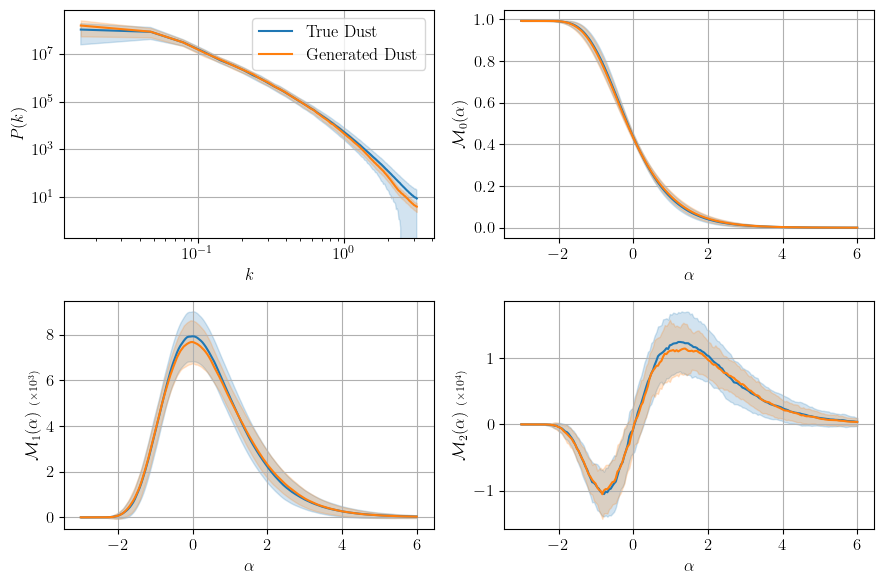

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

axs[0,0].plot(ps_bins, ps_orig, label='True Dust', color='C0')
axs[0,0].fill_between(ps_bins, ps_orig-ps_orig_std, ps_orig+ps_orig_std, alpha=0.2, color='C0')
axs[0,0].plot(ps_bins, ps_samples, label='Generated Dust', color='C1')
axs[0,0].fill_between(ps_bins, ps_samples-ps_samples_std, ps_samples+ps_samples_std, alpha=0.2, color='C1')

axs[0,0].set_xlabel(r'$k$')
axs[0,0].set_ylabel(r'$P(k)$')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0, 0].grid(True)
axs[0,0].legend()

pow_factors = [None, 3, 4] # Renormalization of the Minkowski functionals for better visualization

for i in range(3):
    row = (i + 1)//2
    col = (i + 1)%2

    fac = pow_factors[i]
    label_renorm = ''
    if fac is None:
        fac = 1
    else:
        fac = 10 ** fac
        label_renorm = f'  ${{\\scriptstyle (\\times 10^{{{pow_factors[i]}}})}}$'

    axs[row, col].plot(mink_x, mink_orig_mean[:,i]*fac, color='C0')
    axs[row, col].fill_between(mink_x, (mink_orig_mean[:,i]-mink_orig_std[:,i])*fac, (mink_orig_mean[:,i]+mink_orig_std[:,i])*fac, alpha=0.2, color='C0')
    axs[row, col].plot(mink_x, mink_samples_mean[:,i]*fac, color='C1')
    axs[row, col].fill_between(mink_x, (mink_samples_mean[:,i]-mink_samples_std[:,i])*fac, (mink_samples_mean[:,i]+mink_samples_std[:,i])*fac, alpha=0.2, color='C1')

    axs[row, col].set_xlabel(r'$\alpha$')
    axs[row, col].set_ylabel(f'$\\mathcal{{M}}_{i}(\\alpha)$' + label_renorm)

    axs[row, col].grid(True)

plt.tight_layout()
if save_fig:
    plt.savefig('figs/stats_variant.pdf')
plt.show()

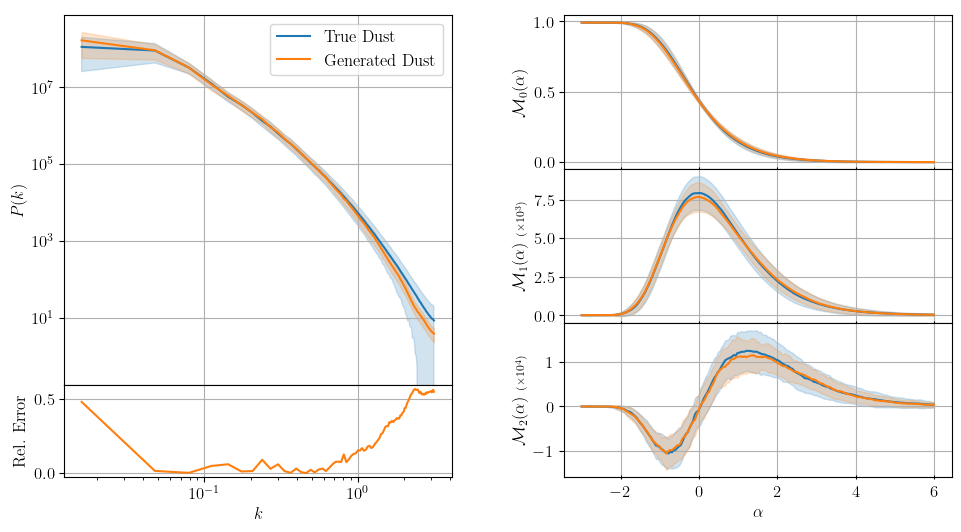

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

subfig = fig.subfigures(1, 2, wspace=0.0)

ax_left = subfig[0].subplots(2, 1, height_ratios=[0.8, 0.2], sharex=True)

ax_left[0].plot(ps_bins, ps_orig, label='True Dust', color='C0')
ax_left[0].fill_between(ps_bins, ps_orig-ps_orig_std, ps_orig+ps_orig_std, alpha=0.2, color='C0')
ax_left[0].plot(ps_bins, ps_samples, label='Generated Dust', color='C1')
ax_left[0].fill_between(ps_bins, ps_samples-ps_samples_std, ps_samples+ps_samples_std, alpha=0.2, color='C1')

ax_left[0].set_ylabel(r'$P(k)$')
ax_left[0].set_xscale('log')
ax_left[0].set_yscale('log')
ax_left[0].legend()

ax_left[1].plot(ps_bins, np.abs(1 - ps_samples/ps_orig), color='C1')

ax_left[1].set_ylabel(r'Rel. Error')
ax_left[1].set_xlabel(r'$k$')

for ax in ax_left:
    ax.grid(True)

ax_right = subfig[1].subplots(3, 1, sharex=True)

pow_factors = [None, 3, 4] # Renormalization of the Minkowski functionals for better visualization

for i in range(3):
    fac = pow_factors[i]
    label_renorm = ''
    if fac is None:
        fac = 1
    else:
        fac = 10 ** fac
        label_renorm = f'  ${{\\scriptstyle (\\times 10^{{{pow_factors[i]}}})}}$'

    ax_right[i].plot(mink_x, mink_orig_mean[:,i]*fac, color='C0')
    ax_right[i].fill_between(mink_x, (mink_orig_mean[:,i]-mink_orig_std[:,i])*fac, (mink_orig_mean[:,i]+mink_orig_std[:,i])*fac, alpha=0.2, color='C0')
    ax_right[i].plot(mink_x, mink_samples_mean[:,i]*fac, color='C1')
    ax_right[i].fill_between(mink_x, (mink_samples_mean[:,i]-mink_samples_std[:,i])*fac, (mink_samples_mean[:,i]+mink_samples_std[:,i])*fac, alpha=0.2, color='C1')

    ax_right[i].tick_params(axis="x",direction="inout")

    ax_right[i].set_ylabel(f'$\\mathcal{{M}}_{i}(\\alpha)$' + label_renorm)
ax_right[2].set_xlabel(r'$\alpha$')

for ax in ax_right:
    ax.grid(True)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
if save_fig:
    plt.savefig('figs/stats.pdf', bbox_inches='tight')
plt.show()